In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/food_rescue_preferences')

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
from rmab.utils import get_results_matching_parameters
from rmab.plots import aggregate_data, aggregate_normalize_data
import seaborn as sns
from rmab.fr_dynamics import get_all_transitions
import random 
import math
from copy import deepcopy
import scipy.stats as stats 

In [4]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')


In [5]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [6]:
colors_by_method = {}
baseline_methods = ['random','shapley_whittle','whittle_activity']
our_methods = ['individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','linear_program']

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(our_methods)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(our_methods):
    colors_by_method[m] = vidris[i]
colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])

## Unknown Transitions Plots

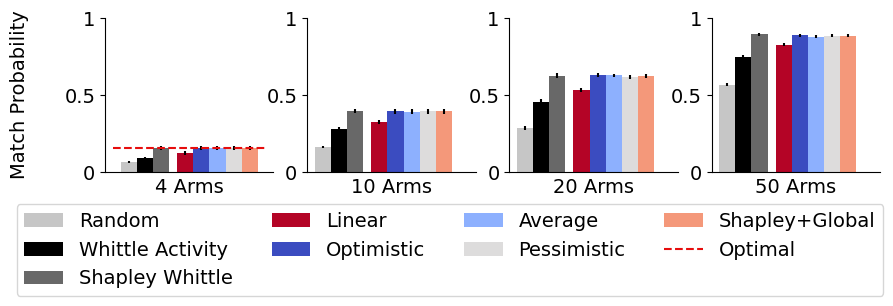

In [7]:
fig, axs = plt.subplots(1,4, figsize=(10, 2))
method_names = ['random','whittle_activity','shapley_whittle','linear_program','individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','optimal']
nice_names = ["Random","Whittle Activity","Shapley Whittle","Linear","Optimistic","Average","Pessimistic","Shapley+Global","Optimal"]
width = 0.1
n_arms = [4,10,20,50]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0, 'prob_distro': 'global_transition','reward_type': 'global_transition'}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_program':
        shift += 0.5 

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    baseline_params['n_arms'] = n
    baseline_params['budget'] = n//2 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "unknown_transitions/baseline_policies"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results)
            if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0,1])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("{} Arms".format(n_arms[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Probability",fontsize=14,x=0.03)
fig.savefig("../../results/figures/transition_n_arms.pdf",dpi=300, bbox_inches='tight')


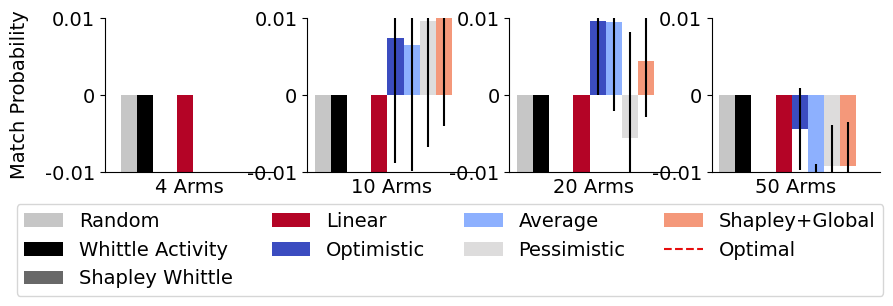

In [8]:
fig, axs = plt.subplots(1,4, figsize=(10, 2))
method_names = ['random','whittle_activity','shapley_whittle','linear_program','individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','optimal']
nice_names = ["Random","Whittle Activity","Shapley Whittle","Linear","Optimistic","Average","Pessimistic","Shapley+Global","Optimal"]
width = 0.1
n_arms = [4,10,20,50]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0, 'prob_distro': 'global_transition','reward_type': 'global_transition'}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_program':
        shift += 0.5 

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    baseline_params['n_arms'] = n
    baseline_params['budget'] = n//2 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "unknown_transitions/baseline_policies"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="shapley_whittle")
            if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([-0.01,0,0.01],[-0.01,0,0.01],fontsize=14)
    axs[i].set_ylim([-0.01,0.01])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("{} Arms".format(n_arms[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Probability",fontsize=14,x=0.03)
fig.savefig("../../results/figures/transition_n_arms.pdf",dpi=300, bbox_inches='tight')


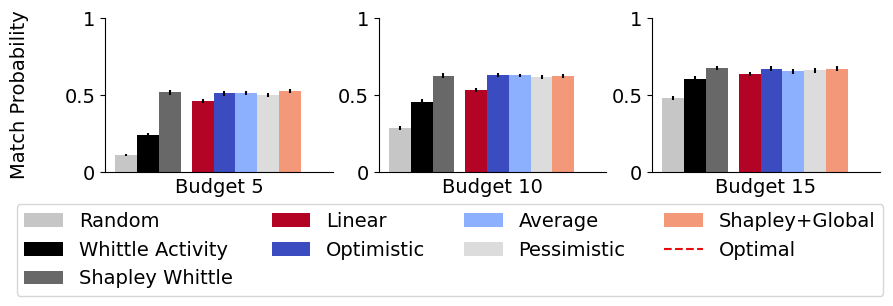

In [9]:
fig, axs = plt.subplots(1,3, figsize=(10, 2))
method_names = ['random','whittle_activity','shapley_whittle','linear_program','individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','optimal']
nice_names = ["Random","Whittle Activity","Shapley Whittle","Linear","Optimistic","Average","Pessimistic","Shapley+Global","Optimal"]
width = 0.1
budgets = [5,10,15]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0, 'prob_distro': 'global_transition','reward_type': 'global_transition','n_arms': 20}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_program':
        shift += 0.5 

    x_locations.append((i+shift)*width)

for i,b in enumerate(budgets):
    baseline_params['n_arms'] = baseline_params['n_arms']
    baseline_params['budget'] = b 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "unknown_transitions/baseline_policies"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_reward'][0])

        if num_data>0:
            results = aggregate_data(results)
            if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([0,0.5,1],[0,0.5,1],fontsize=14)
    axs[i].set_ylim([0,1])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("Budget {}".format(budgets[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Probability",fontsize=14,x=0.03)
fig.savefig("../../results/figures/transition_n_arms.pdf",dpi=300, bbox_inches='tight')


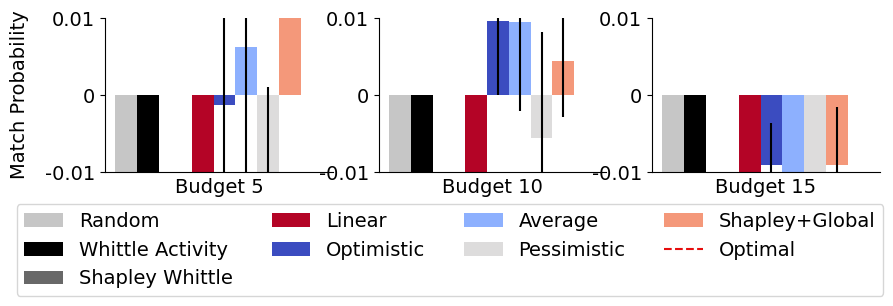

In [10]:
fig, axs = plt.subplots(1,3, figsize=(10, 2))
method_names = ['random','whittle_activity','shapley_whittle','linear_program','individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','optimal']
nice_names = ["Random","Whittle Activity","Shapley Whittle","Linear","Optimistic","Average","Pessimistic","Shapley+Global","Optimal"]
width = 0.1
budgets = [5,10,15]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0, 'prob_distro': 'global_transition','reward_type': 'global_transition','n_arms': 20}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_program':
        shift += 0.5 

    x_locations.append((i+shift)*width)

for i,b in enumerate(budgets):
    baseline_params['n_arms'] = baseline_params['n_arms']
    baseline_params['budget'] = b 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "unknown_transitions/baseline_policies"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline='shapley_whittle')
            if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([-0.01,0,0.01],[-0.01,0,0.01],fontsize=14)
    axs[i].set_ylim([-0.01,0.01])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


for i in range(len(axs)):
    axs[i].set_xlabel("Budget {}".format(budgets[i]),fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Probability",fontsize=14,x=0.03)
fig.savefig("../../results/figures/transition_n_arms.pdf",dpi=300, bbox_inches='tight')


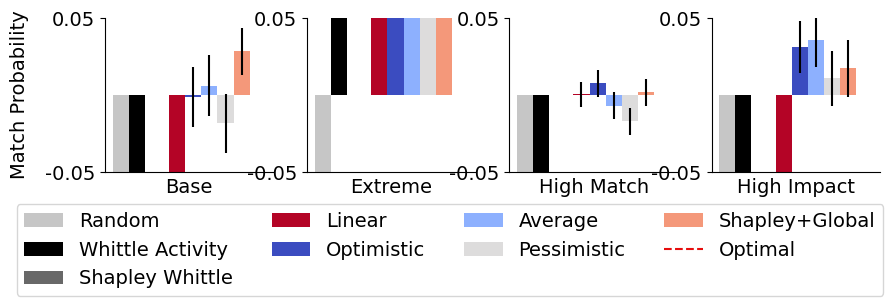

In [11]:
fig, axs = plt.subplots(1,4, figsize=(10, 2))
method_names = ['random','whittle_activity','shapley_whittle','linear_program','individual_optimistic','individual_average','individual_pessimistic','shapley_whittle_global_transition','optimal']
nice_names = ["Random","Whittle Activity","Shapley Whittle","Linear","Optimistic","Average","Pessimistic","Shapley+Global","Optimal"]
width = 0.1
n_arms = ['global_transition','global_transition_extreme' ,'global_transition_high_match','global_transition_high_match_impact']
prob_distros = ["Base","Extreme","High Match","High Impact"]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0, 'prob_distro': 'global_transition','reward_type': 'global_transition', 'n_arms': 20, 'budget': 5}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_program':
        shift += 0.5 

    x_locations.append((i+shift)*width)

for i,d in enumerate(n_arms):
    baseline_params['prob_distro'] = d
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "unknown_transitions/baseline_policies"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline='shapley_whittle')
            if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)

            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    axs[i].set_yticks([-0.05,0.05],[-0.05,0.05],fontsize=14)
    axs[i].set_ylim([-0.05,0.05])

for i in range(len(axs)):
    axs[i].set_xlabel(prob_distros[i],fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Match Probability",fontsize=14,x=0.03)
fig.savefig("../../results/figures/transition_n_arms.pdf",dpi=300, bbox_inches='tight')


## Unknown Parameters

In [12]:
colors_by_method = {}
baseline_methods = ['random','greedy','linear_whittle','shapley_whittle_custom','regression_whittle']
baseline_occupancy = ['occupancy_measure_linear','occupancy_measure_shapley']
learning_methods = ['occupancy_measure_learn_linear','occupancy_measure_learn_shapley','occupancy_measure_learn_shapley_2','occupancy_measure_learn_shapley_3','occupancy_measure_learn_shapley_4']

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
wistia = plt.cm.Wistia(np.linspace(0, 1, len(baseline_occupancy)))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(learning_methods)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(baseline_occupancy):
    colors_by_method[m] = wistia[i]
for i,m in enumerate(learning_methods):
    colors_by_method[m] = vidris[i]

colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])

[[[0.36950082519685556, 0.3061919797819061, 0.3398071353946413, 0.3469372852399827, 0.31713145109124363, 0.29394921698440246, 0.3287591363254402, 0.3135866588053684, 0.31958533625117663, 0.33060576801090114, 0.3801418103972425, 0.3766282110589945, 0.31134685416308716, 0.25864219860436516, 0.22580530848579664, 0.33917111253939997, 0.29793948533607323, 0.27881862347186387, 0.27418166701055985, 0.3063580113534765, 0.19439437134092163, 0.2945819210169602, 0.31177101161664417, 0.25435653766868377, 0.34832158076001235, 0.28202317443463754, 0.3670931512885223, 0.29035722177956913, 0.33194717880454994, 0.3404258295446096]]]


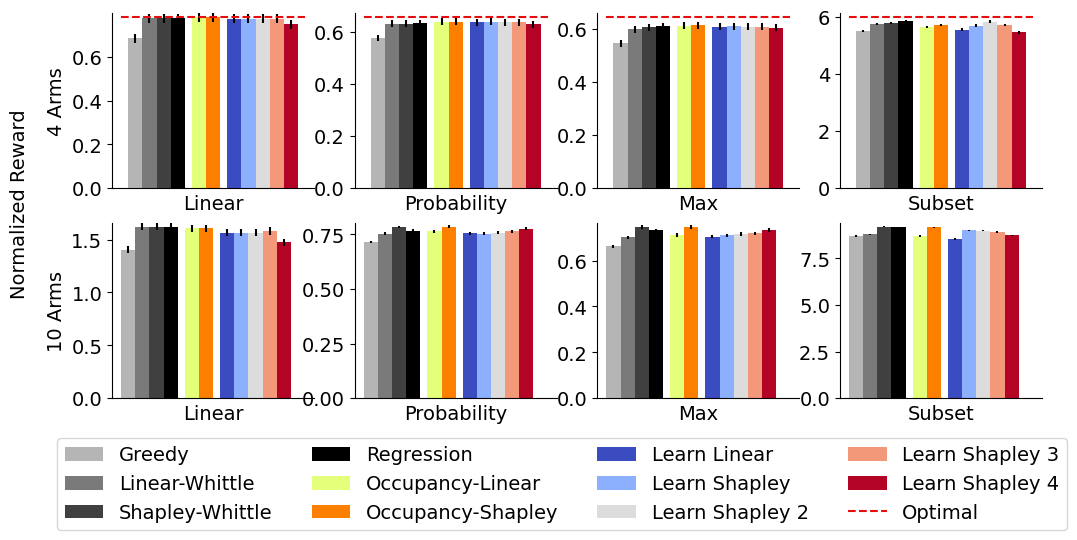

<Figure size 700x400 with 0 Axes>

In [13]:
fig, axs = plt.subplots(2,4, figsize=(12, 5))
method_names = ['greedy','linear_whittle','shapley_whittle_custom','regression_whittle','occupancy_measure_linear','occupancy_measure_shapley','occupancy_measure_learn_linear','occupancy_measure_learn_shapley','occupancy_measure_learn_shapley_2','occupancy_measure_learn_shapley_3','occupancy_measure_learn_shapley_4','optimal']
nice_names = ["Greedy","Linear-Whittle","Shapley-Whittle","Regression","Occupancy-Linear","Occupancy-Shapley","Learn Linear","Learn Shapley","Learn Shapley 2","Learn Shapley 3","Learn Shapley 4","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','n_episodes': 30}
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'occupancy_measure_linear':
        shift += 0.5 
    elif method_names[i] == 'occupancy_measure_learn_linear':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0
        best_baseline_data = []
        max_val = 0

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "unknown_parameters"

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)

            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])

            if n == 4 and j == 0 and m == 'greedy':
                print([i['random_reward'] for i in results if i['parameters']['seed'] == 43])


            if num_data>0:
                results = aggregate_data(results)
                # results = aggregate_normalize_data(results,baseline="random")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                if m == 'optimal' and n == 4:
                    axs[i,j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
                    max_val = results['{}_reward'.format(m)][0]
                else:
                    axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                    if n != 4:
                        max_val = max(max_val,results['{}_reward'.format(m)][0])


        axs[i,j].set_xticks([])

        axs[i,j].tick_params(axis='both', which='major', labelsize=14)


        axs[i,j].set_ylim([0,max_val*1.02])
        axs[i,j].set_xlabel(reward_names[j],fontsize=14)
        

axs[0,0].set_ylabel("4 Arms",fontsize=14)
axs[1,0].set_ylabel("10 Arms",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.04)
fig.savefig("../../results/figures/all_rewards.pdf",dpi=300, bbox_inches='tight')


[1.913978235161077e-16]
[3.0045579739457207e-10]
[1.0408340855860843e-16]
[1.1622647289044608e-16]
[0.040272528048548285]
[0.047150023865372544]
[0.004960866554748875]
[0.05439558326213778]
[0.06347436614704964]
[2.0354088784794535e-15]
[0.4515947620906002]
[0.7619047619047626]
[0.03174582268062294]
[0.031745832139363585]
[3.382710778154774e-16]
[0.039340665384350944]
[0.06037928921913583]
[0.04408715198959844]


/tmp/ipykernel_2836117/3269943038.py:75: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[i,j].set_ylim([0,max_val*1.02])


[0.04026521819586739]
[0.056169827090158435]
[0.06229487117772079]
[0.29189182759646976]
[0.49248232624511445]
[0.7725250002727723]


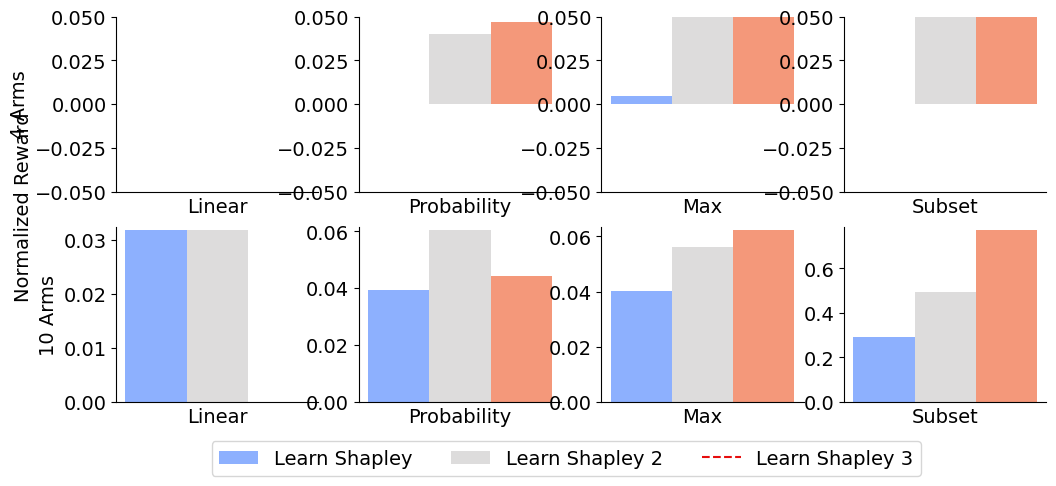

<Figure size 700x400 with 0 Axes>

In [31]:
fig, axs = plt.subplots(2,4, figsize=(12, 5))
method_names = ['occupancy_measure_learn_shapley','occupancy_measure_learn_shapley_2','occupancy_measure_learn_shapley_3']
nice_names = ["Learn Shapley","Learn Shapley 2","Learn Shapley 3"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','n_episodes': 30}
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'occupancy_measure_linear':
        shift += 0.5 
    elif method_names[i] == 'occupancy_measure_learn_linear':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0
        best_baseline_data = []
        max_val = 0

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "unknown_parameters"

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)

            for result in results:
                result['{}_diff_regression'.format(m)] = np.abs(np.array(result['{}_predicted_regression'.format(m)])-np.array(result['{}_actual_regression'.format(m)]))

            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])



            if num_data>0:
                results = aggregate_data(results)
                # results = aggregate_normalize_data(results,baseline="random")


                if '{}_diff_regression'.format(m) not in results:
                    results['{}_diff_regression'.format(m)] = [0]
                score_by_n.append(results['{}_diff_regression'.format(m)][0])
                print(score_by_n)

                axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m])
                if n != 4:
                    max_val = max(max_val,results['{}_diff_regression'.format(m)][0])


        axs[i,j].set_xticks([])

        axs[i,j].tick_params(axis='both', which='major', labelsize=14)


        axs[i,j].set_ylim([0,max_val*1.02])
        axs[i,j].set_xlabel(reward_names[j],fontsize=14)
        

axs[0,0].set_ylabel("4 Arms",fontsize=14)
axs[1,0].set_ylabel("10 Arms",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.04)
fig.savefig("../../results/figures/all_rewards.pdf",dpi=300, bbox_inches='tight')


[[[0.3061919797819061, 0.3398071353946413, 0.3469372852399827, 0.31713145109124363, 0.29394921698440246, 0.3287591363254402, 0.3135866588053684, 0.31958533625117663, 0.33060576801090114, 0.3801418103972425, 0.3766282110589945, 0.31134685416308716, 0.25864219860436516, 0.22580530848579664, 0.33917111253939997, 0.29793948533607323, 0.27881862347186387, 0.27418166701055985, 0.3063580113534765, 0.19439437134092163, 0.2945819210169602, 0.31177101161664417, 0.25435653766868377, 0.34832158076001235, 0.28202317443463754, 0.3670931512885223, 0.29035722177956913, 0.33194717880454994, 0.3404258295446096]]]


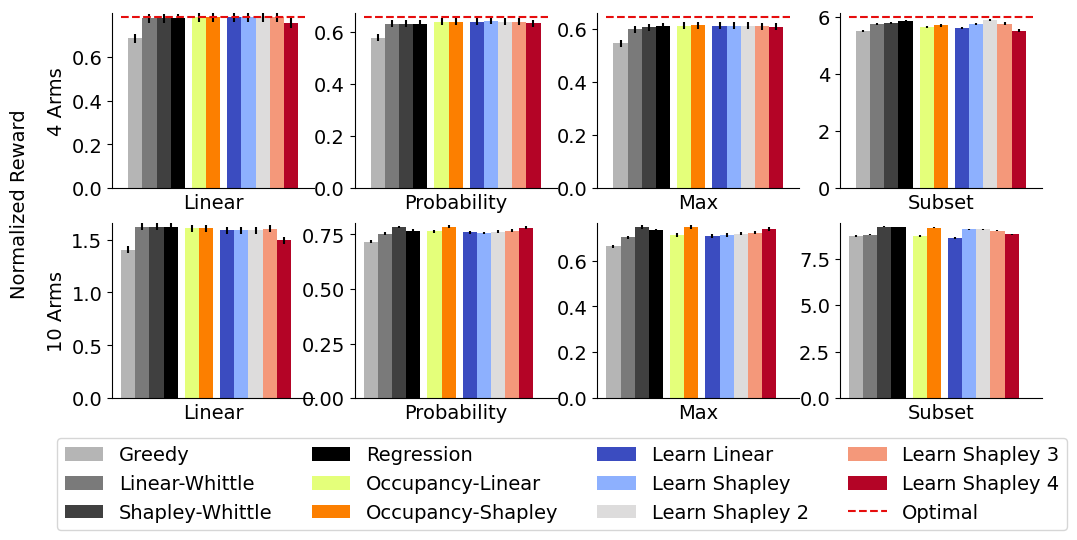

<Figure size 700x400 with 0 Axes>

In [14]:
fig, axs = plt.subplots(2,4, figsize=(12, 5))
method_names = ['greedy','linear_whittle','shapley_whittle_custom','regression_whittle','occupancy_measure_linear','occupancy_measure_shapley','occupancy_measure_learn_linear','occupancy_measure_learn_shapley','occupancy_measure_learn_shapley_2','occupancy_measure_learn_shapley_3','occupancy_measure_learn_shapley_4','optimal']
nice_names = ["Greedy","Linear-Whittle","Shapley-Whittle","Regression","Occupancy-Linear","Occupancy-Shapley","Learn Linear","Learn Shapley","Learn Shapley 2","Learn Shapley 3","Learn Shapley 4","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','n_episodes': 30}
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'occupancy_measure_linear':
        shift += 0.5 
    elif method_names[i] == 'occupancy_measure_learn_linear':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0
        best_baseline_data = []
        max_val = 0

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "unknown_parameters"

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)

            for result in results:
                for key in result:
                    if 'reward' in key:
                        result[key] = [result[key][0][1:]]

            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])

            if n == 4 and j == 0 and m == 'greedy':
                print([i['random_reward'] for i in results if i['parameters']['seed'] == 43])


            if num_data>0:
                results = aggregate_data(results)
                # results = aggregate_normalize_data(results,baseline="random")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                if m == 'optimal' and n == 4:
                    axs[i,j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
                    max_val = results['{}_reward'.format(m)][0]
                else:
                    axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                    if n != 4:
                        max_val = max(max_val,results['{}_reward'.format(m)][0])


        axs[i,j].set_xticks([])

        axs[i,j].tick_params(axis='both', which='major', labelsize=14)


        axs[i,j].set_ylim([0,max_val*1.02])
        axs[i,j].set_xlabel(reward_names[j],fontsize=14)
        

axs[0,0].set_ylabel("4 Arms",fontsize=14)
axs[1,0].set_ylabel("10 Arms",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.04)
fig.savefig("../../results/figures/all_rewards.pdf",dpi=300, bbox_inches='tight')
